1. Обучить полносвязную модель на MNIST
1. Обучить глубокую сверточную сеть на MNIST
1. *Обучить с нуля глубокую сеть на небольшом датасете. Сравнить результат с дообучением предобученной сети. CIFAR-10

In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor

In [12]:
# Create data loaders.
train_data = datasets.MNIST(root='.', train=True,
                            download=True, transform=ToTensor())
test_data = datasets.MNIST(root='.', train=False,
                           download=True, transform=ToTensor())
train_dataloader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

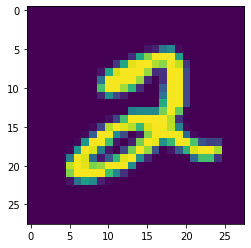

In [3]:
plt.imshow(train_data.data[5].detach().numpy())
plt.show()

Обучить полносвязную модель на MNIST

In [4]:
# hyperparameters for full connection network:
BATCH_SIZE = 128
FULL_NN = ((28 * 28, 500), (500, 250), (250, 10))
L_R = 1e-3

In [5]:
class FullModel(nn.Module):
    def __init__(self, arch: tuple[tuple[int, int]], do_p=0.1, activ='relu'):
        super().__init__()
        self.flat = nn.Flatten()
        self.seq = nn.Sequential()
        for inp, out in arch[:-1]:
            self.seq.append(nn.Linear(inp, out))
            if activ.lower() == 'relu':
                self.seq.append(nn.ReLU())
            elif active.lower() == 'sigmoid':
                self.seq.append(nn.Sigmoid())
            self.seq.append(nn.Dropout(do_p))
        self.seq.append(nn.Linear(*arch[-1]))
        
    def forward(self, x):
        x = self.flat(x)
        logits = self.seq(x)
        return logits    

In [7]:
model = FullModel(FULL_NN)
model

FullModel(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (seq): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=500, out_features=250, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=250, out_features=10, bias=True)
  )
)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=L_R)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print('Test Error:')
    print(f'Accuracy: {(100 * correct):>0.1f}%,', end=' ')
    print(f'Avg loss: {test_loss:>8f} \n')

In [13]:
epochs = 6
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optim)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298320 [    0/60000]
loss: 0.275148 [12800/60000]
loss: 0.389434 [25600/60000]
loss: 0.101836 [38400/60000]
loss: 0.172085 [51200/60000]
Test Error:
Accuracy: 96.2%, Avg loss: 0.123376 

Epoch 2
-------------------------------
loss: 0.174009 [    0/60000]
loss: 0.167481 [12800/60000]
loss: 0.104810 [25600/60000]
loss: 0.077570 [38400/60000]
loss: 0.134580 [51200/60000]
Test Error:
Accuracy: 97.2%, Avg loss: 0.089144 

Epoch 3
-------------------------------
loss: 0.079036 [    0/60000]
loss: 0.081160 [12800/60000]
loss: 0.046381 [25600/60000]
loss: 0.058492 [38400/60000]
loss: 0.037801 [51200/60000]
Test Error:
Accuracy: 97.6%, Avg loss: 0.072532 

Epoch 4
-------------------------------
loss: 0.022561 [    0/60000]
loss: 0.049191 [12800/60000]
loss: 0.126939 [25600/60000]
loss: 0.089375 [38400/60000]
loss: 0.102974 [51200/60000]
Test Error:
Accuracy: 97.7%, Avg loss: 0.066182 

Epoch 5
-------------------------------
loss: 0.013374 [    

In [14]:
def check(k):
    print('predict:', model(test_data[k][0]).argmax(1).item())
    print('true:', test_data[k][1])
    plt.imshow(test_data.data[k].detach().numpy())
    plt.show()

predict: 9
true: 9


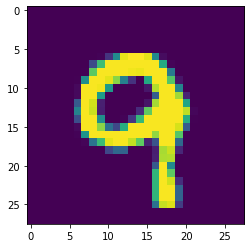

In [15]:
check(99)

Обучить глубокую сверточную сеть на MNIST

In [16]:
class ConvNetwork(nn.Module):
    def __init__(self, input_ch, hidden_ch, out_ch, out_dim, do_prob=0.1):
        super().__init__()
        self.seq = nn.Sequential()
        self.seq.append(nn.Conv2d(input_ch, hidden_ch,
                        kernel_size=5, stride=2, padding=2))
        self.seq.append(nn.BatchNorm2d(hidden_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_prob))
        self.seq.append(nn.Conv2d(hidden_ch, hidden_ch,
                        kernel_size=3, stride=1, padding=1))
        self.seq.append(nn.BatchNorm2d(hidden_ch))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Dropout(do_prob))
        self.seq.append(nn.Conv2d(hidden_ch, out_ch,
                        kernel_size=3, stride=1, padding=1))
        self.seq.append(nn.Flatten())
        self.seq.append(nn.Linear(out_ch*14*14, out_dim))

    def forward(self, x):
        logits = self.seq(x)
        return logits

In [17]:
# Hyperparameters of convolutional network
INP_CHAN = 1
HID_CHAN = 128
OUT_CHAN = 5
OUT_DIM = 10

In [18]:
conv_model = ConvNetwork(INP_CHAN, HID_CHAN, OUT_CHAN, OUT_DIM)
conv_loss_fn = nn.CrossEntropyLoss()
conv_optim = torch.optim.Adam(conv_model.parameters())
conv_model

ConvNetwork(
  (seq): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(128, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=980, out_features=10, bias=True)
  )
)

In [19]:
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, conv_model, conv_loss_fn, conv_optim)
    test(test_dataloader, conv_model, conv_loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.347651 [    0/60000]
loss: 0.099823 [12800/60000]
loss: 0.061236 [25600/60000]
loss: 0.047796 [38400/60000]
loss: 0.054542 [51200/60000]
Test Error:
Accuracy: 98.0%, Avg loss: 0.055489 

Epoch 2
-------------------------------
loss: 0.025129 [    0/60000]
loss: 0.056620 [12800/60000]
loss: 0.108810 [25600/60000]
loss: 0.029715 [38400/60000]
loss: 0.044570 [51200/60000]
Test Error:
Accuracy: 98.4%, Avg loss: 0.042021 

Epoch 3
-------------------------------
loss: 0.073155 [    0/60000]
loss: 0.043593 [12800/60000]
loss: 0.040637 [25600/60000]
loss: 0.066073 [38400/60000]
loss: 0.078932 [51200/60000]
Test Error:
Accuracy: 98.2%, Avg loss: 0.047302 

Epoch 4
-------------------------------
loss: 0.077586 [    0/60000]
loss: 0.140378 [12800/60000]
loss: 0.024889 [25600/60000]
loss: 0.097810 [38400/60000]
loss: 0.034879 [51200/60000]
Test Error:
Accuracy: 98.8%, Avg loss: 0.032914 

Done!


10.5770845413208 2 2
10.191317558288574 9 9
13.033565521240234 0 0
9.242420196533203 7 7
5.584604740142822 5 9
9.553967475891113 1 1
7.081634044647217 0 0
12.25412654876709 7 7
15.521939277648926 7 7
13.491518020629883 9 9
11.447035789489746 8 8
12.108256340026855 2 2


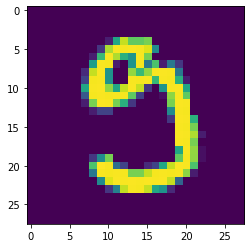

In [22]:
with torch.no_grad():
    for n, (X, y) in enumerate(test_dataloader):
        pred = model(X)
        print(pred[1].max().item(), pred[1].argmax().item(), y[1].item())
        if pred[1].argmax().item() != y[1].item():
            plt.imshow(X[1].squeeze().numpy())
        if n > 10:
            break